In [2]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import os
datasetX = "./data/datasetX.csv"
datasety = "./data/datasety.csv"

def load_dt():
    if os.path.exists(datasetX) and os.path.exists(datasety):
        X = pd.read_csv(datasetX)
        y = pd.read_csv(datasety)
        return X, y
    else:
        heart_disease = fetch_ucirepo(id=45)
        X = heart_disease.data.features.copy()
        y = heart_disease.data.targets.copy()
        
        missing_values = X.isnull().sum()
        # n de elementos faltantes pra cada col
        # print(missing_values)
        # Substituindo valores faltantes em 'ca' pela média
        X['ca'] = X['ca'].fillna(X['ca'].mean())
        # Substituindo valores faltantes em 'thal' pela moda
        X['thal'] = X['thal'].fillna(X['thal'].mode()[0])
        
        y["num"] = y["num"].apply(lambda x: 1 if x > 0 else 0)

        
        X.to_csv(datasetX, index=False)
        y.to_csv(datasety, index=False)
        return X,y
X, y = load_dt()

## Distribuição de Variáveis

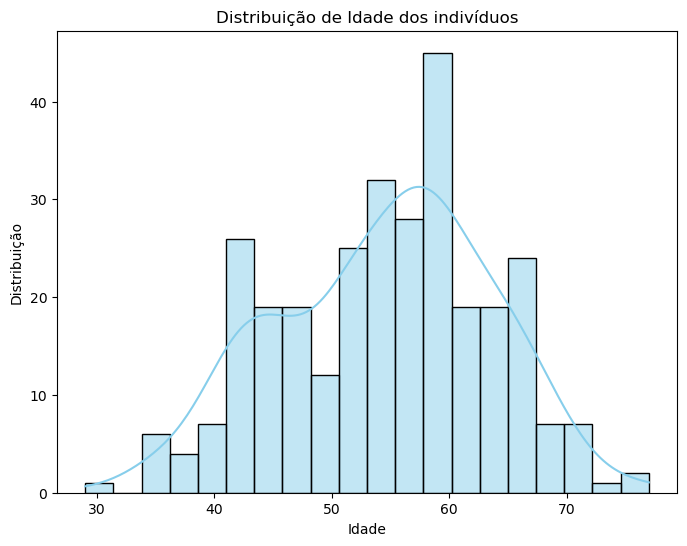

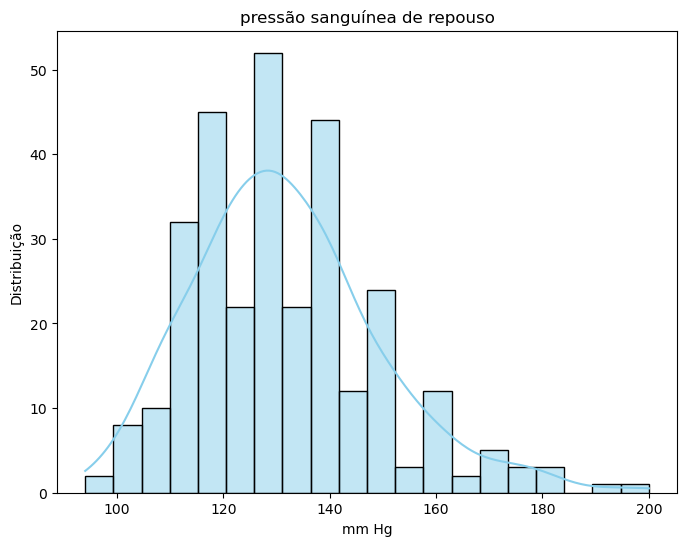

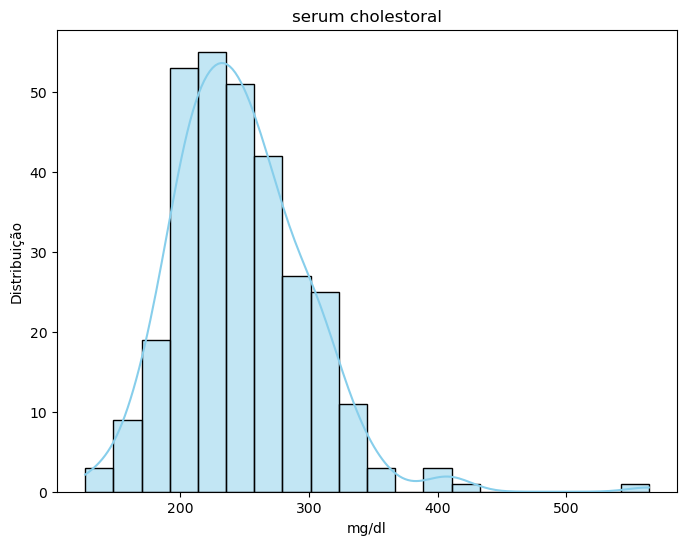

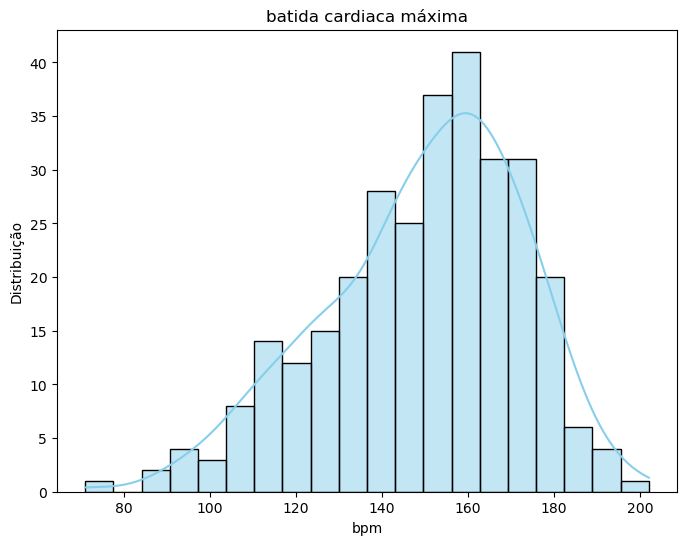

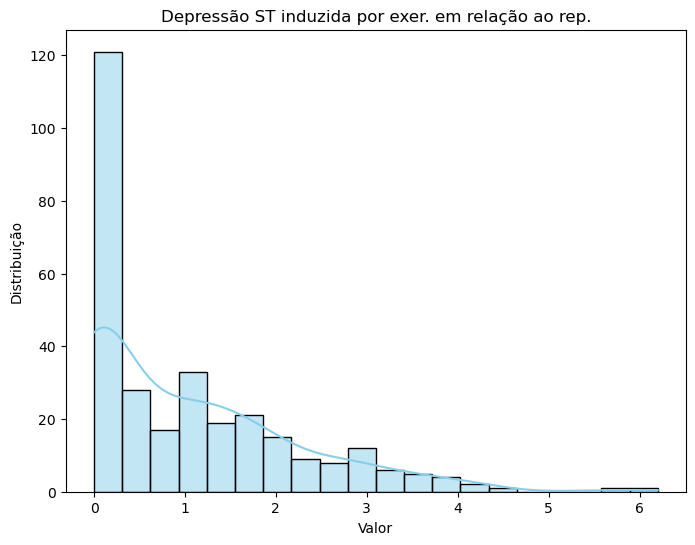

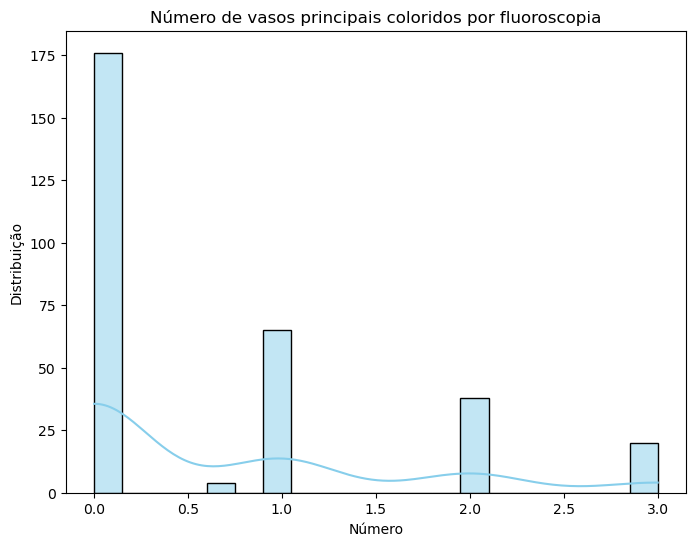

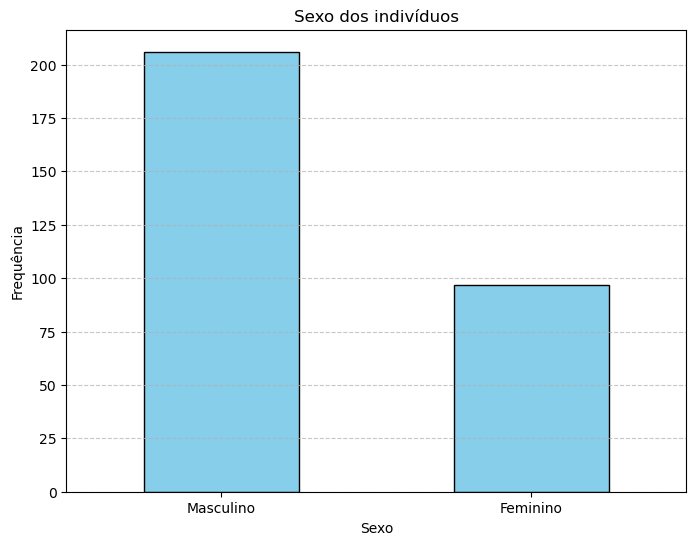

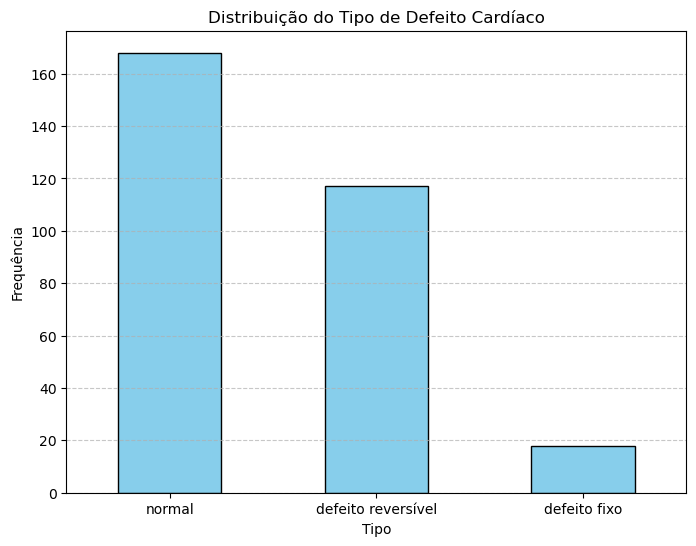

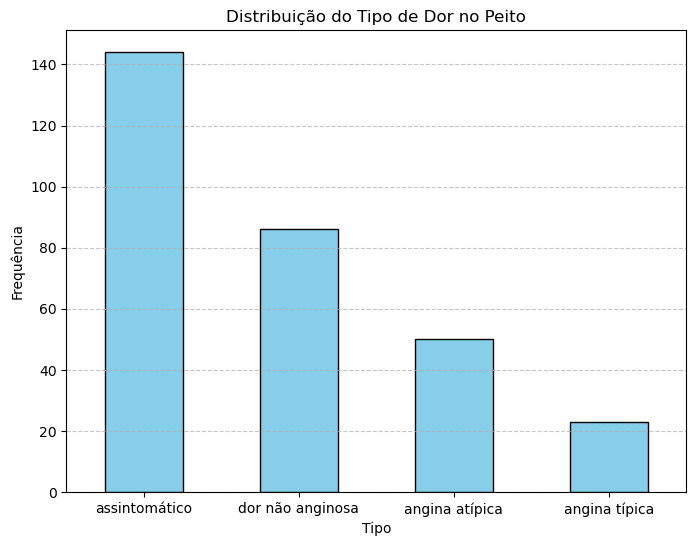

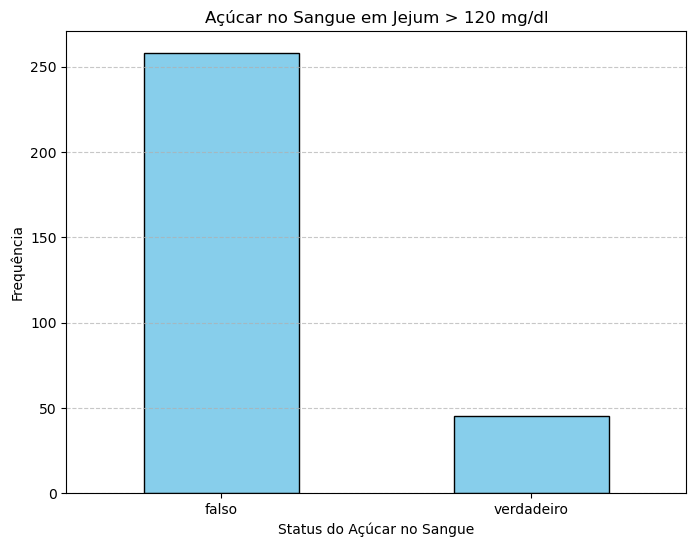

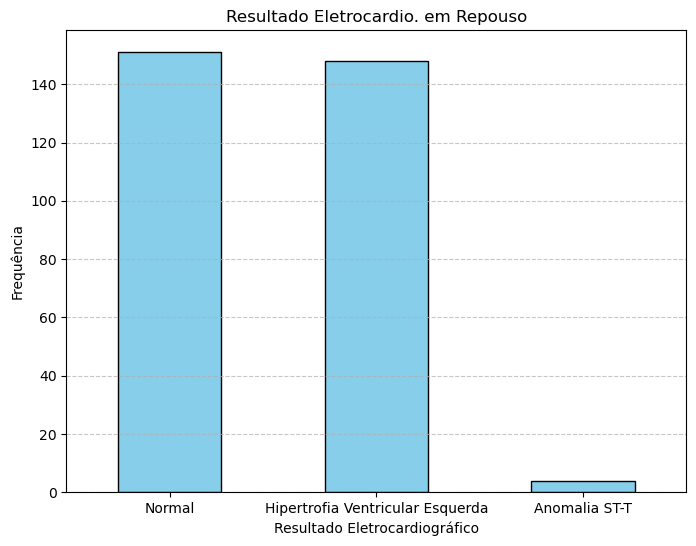

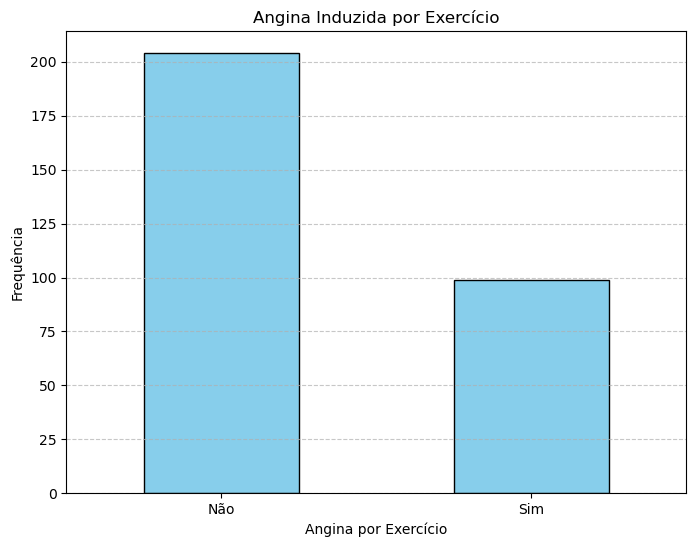

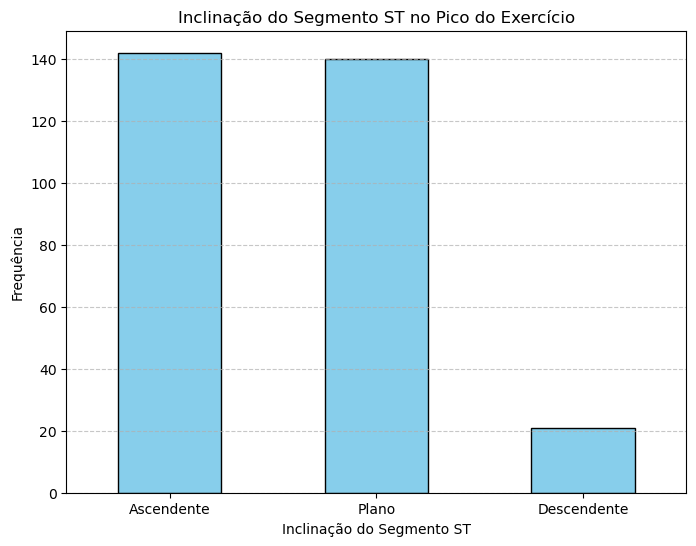

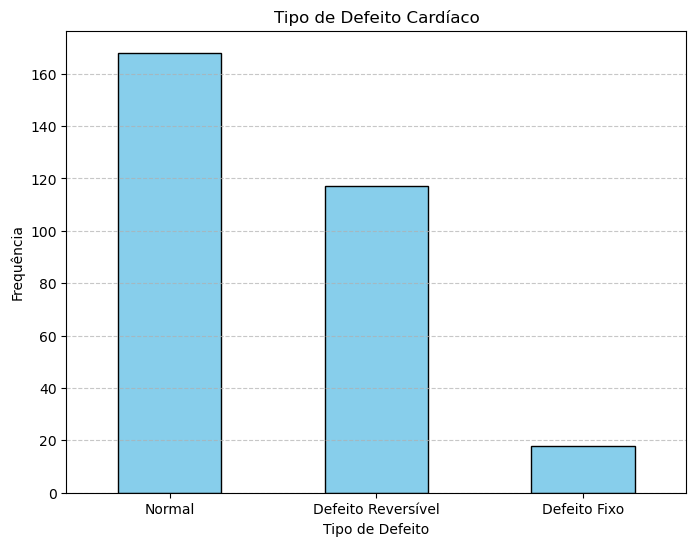

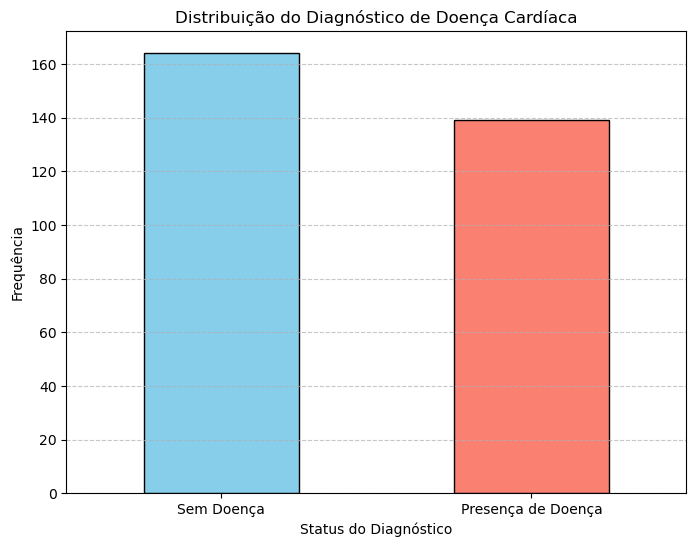

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
Xcat_info = [
    # (coluna, desc1, desc2, valores)
    ("sex", "Sexo dos indivíduos", "Sexo", {0: "Feminino", 1: "Masculino"}),
    ("thal", "Distribuição do Tipo de Defeito Cardíaco", "Tipo", {3: "normal", 6: "defeito fixo", 7: "defeito reversível"}),
    ("cp", "Distribuição do Tipo de Dor no Peito", "Tipo", {1: "angina típica", 2: "angina atípica", 3: "dor não anginosa", 4: "assintomático"}),
    ("fbs", "Açúcar no Sangue em Jejum > 120 mg/dl", "Status do Açúcar no Sangue", {0: "falso", 1: "verdadeiro"}),
    ("restecg", "Resultado Eletrocardio. em Repouso", "Resultado Eletrocardiográfico", {0: "Normal", 1: "Anomalia ST-T", 2: "Hipertrofia Ventricular Esquerda"}),
    ("exang", "Angina Induzida por Exercício", "Angina por Exercício", {0: "Não", 1: "Sim"}),
    ("slope", "Inclinação do Segmento ST no Pico do Exercício", "Inclinação do Segmento ST", {1: "Ascendente", 2: "Plano", 3: "Descendente"}),
    ("thal", "Tipo de Defeito Cardíaco", "Tipo de Defeito", {3: "Normal", 6: "Defeito Fixo", 7: "Defeito Reversível"}),
]
Xnum_info = [
    # (coluna, desc1, desc2)
    ("age", "Distribuição de Idade dos indivíduos", "Idade"),
    ("trestbps", "pressão sanguínea de repouso", "mm Hg"),
    ("chol", "serum cholestoral", "mg/dl"),
    ("thalach", "batida cardiaca máxima", "bpm"),
    ("oldpeak", "Depressão ST induzida por exer. em relação ao rep.", "Valor"),
    ("ca", "Número de vasos principais coloridos por fluoroscopia", "Número"),
]

for col, title, xlabel in Xnum_info:
    # Variável Independente Quantitativa
    plt.figure(figsize=(8, 6))
    sns.histplot(X[col], kde=True, color='skyblue', bins=20)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Distribuição')
    plt.show()
    
for var, title, xlabel, labels in Xcat_info:
    # Variável Independente Categóricas
    plt.figure(figsize=(8, 6))
    
    # Contagem de valores da variável
    counts = X[var].map(labels).value_counts()
    
    # Barplot
    counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequência")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show


# Variável dependente
plt.figure(figsize=(8, 6))
y.value_counts().plot(kind="bar", color=["skyblue", "salmon"], edgecolor="black")
plt.title("Distribuição do Diagnóstico de Doença Cardíaca")
plt.xlabel("Status do Diagnóstico")
plt.ylabel("Frequência")
plt.xticks([0, 1], ['Sem Doença', 'Presença de Doença'], rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## Correlação entre Variáveis Independentes e Variável Dependente

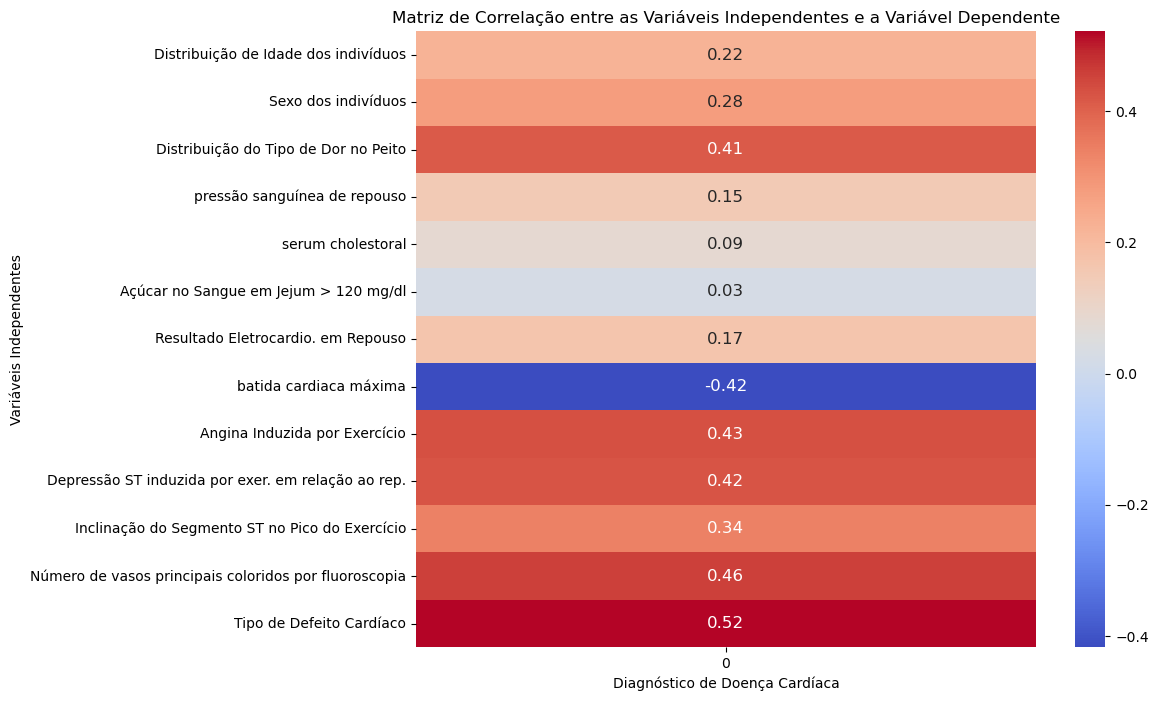

In [8]:
# Remapeamento das variáveis independentes para nomes descritivos em português
Xcol_nomes = {}

for col, nome, _, _ in Xcat_info:
    Xcol_nomes[col]=nome
for col, nome, _ in Xnum_info:
    Xcol_nomes[col]=nome

X_renamed = X.rename(columns=Xcol_nomes)

# Remapeamento da variável dependente
y_renamed = y.rename(columns={"num": "Diagnóstico de Doença Cardíaca"})
# Calculando a correlação entre as variáveis independentes e a variável dependente
correlation_matrix = X_renamed.corrwith(y_renamed["Diagnóstico de Doença Cardíaca"])

# Plotando a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', cbar=True, fmt=".2f", annot_kws={"size": 12})
plt.title("Matriz de Correlação entre as Variáveis Independentes e a Variável Dependente")
plt.ylabel("Variáveis Independentes")
plt.xlabel("Diagnóstico de Doença Cardíaca")
plt.show()

In [10]:
from scipy.stats import chi2_contingency, f_oneway


alpha = 0.05
print(f"Nível de significância estabelecido: {alpha}")

#teste Qui-Quadrado
def chi_squared_test(x, y):
    # tabela de contingência
    contingency_table = pd.crosstab(x, y)
    # teste Qui-Quadrado
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p  # valor p

# teste ANOVA
def anova_test(x, y):
    # variáveis numéricas por categoria de 'y'
    groups = [x[y == category] for category in y.unique()]
    # teste ANOVA
    f_stat, p_value = f_oneway(*groups)
    return p_value  # valor p

print("Teste de hipóteses")

# Teste Qui-Quadrado para cada variável categórica
categorical_vars = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
for var in categorical_vars:
    p_value = chi_squared_test(X[var], y["num"])
    print(f'Teste Qui-Quadrado para {Xcol_nomes.get(var, var)}: p-value = {p_value:.4f}')
    
    
    
    if p_value < alpha:
        print(f'A hipótese nula é rejeitada para {Xcol_nomes.get(var, var)}: Existe uma associação significativa.')
    else:
        print(f'A hipótese nula não é rejeitada para {Xcol_nomes.get(var, var)}: Não há associação significativa.')
    print("")
    
# Teste ANOVA para cada variável numérica
numerical_vars = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
for var in numerical_vars:
    p_value = anova_test(X[var], y["num"])
    print(f'Teste ANOVA para {Xcol_nomes.get(var, var)}: p-value = {p_value:.4f}')
    
    # Condicional para verificar a hipótese
    if p_value < alpha:
        print(f'A hipótese nula é rejeitada para {Xcol_nomes.get(var, var)}: Existe uma diferença significativa nas médias.')
    else:
        print(f'A hipótese nula não é rejeitada para {Xcol_nomes.get(var, var)}: Não há diferença significativa nas médias.')
    print("")

Nível de significância estabelecido: 0.05
Teste de hipóteses
Teste Qui-Quadrado para Sexo dos indivíduos: p-value = 0.0000
A hipótese nula é rejeitada para Sexo dos indivíduos: Existe uma associação significativa.

Teste Qui-Quadrado para Distribuição do Tipo de Dor no Peito: p-value = 0.0000
A hipótese nula é rejeitada para Distribuição do Tipo de Dor no Peito: Existe uma associação significativa.

Teste Qui-Quadrado para Açúcar no Sangue em Jejum > 120 mg/dl: p-value = 0.7813
A hipótese nula não é rejeitada para Açúcar no Sangue em Jejum > 120 mg/dl: Não há associação significativa.

Teste Qui-Quadrado para Resultado Eletrocardio. em Repouso: p-value = 0.0066
A hipótese nula é rejeitada para Resultado Eletrocardio. em Repouso: Existe uma associação significativa.

Teste Qui-Quadrado para Angina Induzida por Exercício: p-value = 0.0000
A hipótese nula é rejeitada para Angina Induzida por Exercício: Existe uma associação significativa.

Teste Qui-Quadrado para Inclinação do Segmento ST

## Regressão Logística

In [14]:
# bibliotecas da etapa
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X_scaled = X.copy()

# Inicializando o LabelEncoder para variáveis categóricas
label_encoders = {}

for col, nome, desc, tipos in Xcat_info:
    le = LabelEncoder()
    X_scaled[col] = le.fit_transform(X_scaled[col])  # Convertendo para valores numéricos
    label_encoders[col] = le  # Armazenando o encoder

# Escalonamento dos dados numéricos
scaler = StandardScaler()

# Aplicando o escalonamento nas variáveis numéricas
numerical_vars = [x[0] for x in Xnum_info]
X_scaled[numerical_vars] = scaler.fit_transform(X[numerical_vars])

# Treinamento e Teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y["num"], test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# avaliação do modelo
y_pred = model.predict(X_test)

# performance
print("Acurácia do modelo:", accuracy_score(y_test, y_pred))

# parâmetro zero_division=1 para evitar problemas de métricas indefinidas
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, zero_division=1))

probabilities = model.predict_proba(X_test)
print("Probabilidades para as primeiras 5 observações:", probabilities[:5])


Acurácia do modelo: 0.8852459016393442
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61

Probabilidades para as primeiras 5 observações: [[0.28385283 0.71614717]
 [0.23382834 0.76617166]
 [0.2357931  0.7642069 ]
 [0.48309505 0.51690495]
 [0.34890834 0.65109166]]


## Árvore de Decisão com Validação Cruzada

In [18]:
# bibliotecas da etapa
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

label_encoder = LabelEncoder()
X_f = X.copy()
# Aplicando LabelEncoder para cada variável categórica
for col, _, _, _ in Xcat_info:
    X_f[col] = label_encoder.fit_transform(X_f[col])

# Dividir os dados em treino e teste para validação
X_train, X_test, y_train, y_test = train_test_split(X_f, y, test_size=0.3, random_state=42)

# Criação do modelo de Árvore de Decisão
model = DecisionTreeClassifier(random_state=42)

# Realizar a validação cruzada (K-fold Cross Validation)
cv_scores = cross_val_score(model, X_f, y, cv=5)  # Usando 5 folds para validação cruzada

# Mostrar os resultados da validação cruzada
print(f"Acurácia média da validação cruzada: {cv_scores.mean():.4f}")
print(f"Desvio padrão da acurácia: {cv_scores.std():.4f}")

# Treinando o modelo completo nos dados de treino
model.fit(X_train, y_train)

# Realizar previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar a performance do modelo
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))



Acurácia média da validação cruzada: 0.7655
Desvio padrão da acurácia: 0.0834

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        48
           1       0.68      0.70      0.69        43

    accuracy                           0.70        91
   macro avg       0.70      0.70      0.70        91
weighted avg       0.70      0.70      0.70        91



## Árvore de Decisão e Random Forest

In [19]:
# Bibliotecas necessárias para essa etapa
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE


# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convertendo y para um vetor unidimensional, necessário para o sklearn
y_train = y_train.values.ravel()  # Corrigido para garantir que y seja 1D
y_test = y_test.values.ravel()    # Corrigido para garantir que y seja 1D

# Aplicando SMOTE para lidar com desbalanceamento de classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Criação dos modelos
# Modelo de Árvore de Decisão
dt_model = DecisionTreeClassifier(random_state=42)

# Modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Treinando os modelos
dt_model.fit(X_train_smote, y_train_smote)
rf_model.fit(X_train_smote, y_train_smote)

# Realizando a validação cruzada (K-fold Cross Validation) para ambos os modelos
dt_cv_scores = cross_val_score(dt_model, X_train_smote, y_train_smote, cv=5)
rf_cv_scores = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=5)

# Exibindo os resultados da validação cruzada
print(f"Acurácia média da validação cruzada (Árvore de Decisão): {dt_cv_scores.mean():.4f}")
print(f"Desvio padrão da acurácia (Árvore de Decisão): {dt_cv_scores.std():.4f}")
print(f"Acurácia média da validação cruzada (Random Forest): {rf_cv_scores.mean():.4f}")
print(f"Desvio padrão da acurácia (Random Forest): {rf_cv_scores.std():.4f}")

# Realizando previsões no conjunto de teste para ambos os modelos
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Avaliar a performance dos modelos (Relatório de Classificação)
print("\nRelatório de Classificação (Árvore de Decisão):")
print(classification_report(y_test, y_pred_dt))

print("\nRelatório de Classificação (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Binarizar as saídas de y para múltiplas classes
y_train_bin = label_binarize(y_train_smote, classes=[0, 1, 2, 3, 4])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Cálculo do AUC-ROC para a Árvore de Decisão
y_pred_prob_dt = dt_model.predict_proba(X_test)
roc_auc_dt = roc_auc_score(y_test_bin, y_pred_prob_dt, average='macro', multi_class='ovr')
print(f"\nAUC-ROC (Árvore de Decisão): {roc_auc_dt:.4f}")

# Cálculo do AUC-ROC para o Random Forest
y_pred_prob_rf = rf_model.predict_proba(X_test)
roc_auc_rf = roc_auc_score(y_test_bin, y_pred_prob_rf, average='macro', multi_class='ovr')
print(f"\nAUC-ROC (Random Forest): {roc_auc_rf:.4f}")


Acurácia média da validação cruzada (Árvore de Decisão): 0.7540
Desvio padrão da acurácia (Árvore de Decisão): 0.0497
Acurácia média da validação cruzada (Random Forest): 0.7797
Desvio padrão da acurácia (Random Forest): 0.0570

Relatório de Classificação (Árvore de Decisão):
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        48
           1       0.74      0.74      0.74        43

    accuracy                           0.76        91
   macro avg       0.76      0.76      0.76        91
weighted avg       0.76      0.76      0.76        91


Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        48
           1       0.81      0.88      0.84        43

    accuracy                           0.85        91
   macro avg       0.85      0.85      0.85        91
weighted avg       0.85      0.85      0.85        91


AUC-ROC (Árvore de Deci

## XGBoost

In [20]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

# Divisão dos dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y["num"], test_size=0.3, random_state=42)

# Criação do modelo XGBoost
model = xgb.XGBClassifier(objective="multi:softmax", num_class=5, eval_metric="mlogloss", use_label_encoder=False)

# Validação cruzada com K-fold (número de splits = 5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")

# Resultado da validação cruzada
print(f"Acurácia média da validação cruzada: {cv_results.mean():.4f} +/- {cv_results.std():.4f}")

# Treinando o modelo
model.fit(X_train, y_train)

# Prevendo com o conjunto de teste
y_pred = model.predict(X_test)

# Avaliação do modelo
print("Relatório de Classificação no conjunto de teste:")
print(classification_report(y_test, y_pred))

# Acurácia no conjunto de teste
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")


Acurácia média da validação cruzada: 0.7831 +/- 0.0273
Relatório de Classificação no conjunto de teste:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80        48
           1       0.76      0.81      0.79        43

    accuracy                           0.79        91
   macro avg       0.79      0.79      0.79        91
weighted avg       0.79      0.79      0.79        91

Acurácia no conjunto de teste: 0.7912


## Máquinas de Vetores de Suporte (SVM)

In [21]:
# Importando as bibliotecas necessárias
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE  # Para balanceamento das classes


y_f = y["num"].values

# Normalizando as variáveis numéricas
cols = [x[0] for x in Xnum_info]

X_f[cols] = scaler.fit_transform(X[cols])


X_train, X_test, y_train, y_test = train_test_split(X, y_f, test_size=0.2, random_state=42, stratify=y_f)

# Aplicando SMOTE para balancear as classes no conjunto de treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Criando e treinando o modelo SVM com kernel linear
svm_model = SVC(kernel='linear', random_state=42)

# Aplicando validação cruzada no conjunto balanceado
cv_scores = cross_val_score(svm_model, X_train_res, y_train_res, cv=StratifiedKFold(5), scoring='accuracy')

# Mostrando a acurácia média da validação cruzada
print(f'Acurácia média (Validação Cruzada): {cv_scores.mean():.4f}')
print(f'Desvio padrão da acurácia: {cv_scores.std():.4f}')

# Treinando o modelo com os dados balanceados
svm_model.fit(X_train_res, y_train_res)

# Fazendo previsões no conjunto de teste original (não balanceado)
y_pred = svm_model.predict(X_test)

# Exibindo métricas de desempenho
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


Acurácia média (Validação Cruzada): 0.8242
Desvio padrão da acurácia: 0.0338

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.93      0.79      0.85        33
           1       0.79      0.93      0.85        28

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61


Matriz de Confusão:
[[26  7]
 [ 2 26]]
